In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [63]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy


# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
inspector=inspect(engine)

In [7]:
inspector.get_table_names()

['measurement', 'station']

In [8]:
inspector.get_columns('measurement')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [9]:
data = engine.execute("select * from station" )
for record in data:
    print(record)

(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)
(5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)
(6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
(7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
(8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9)
(9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)


In [10]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(autoload_with=engine)


In [11]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [26]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [18]:
from datetime import datetime, timedelta 

In [19]:
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

In [20]:
recent_date

('2017-08-23',)

In [22]:
recent_date = datetime.strptime(recent_date.date, '%Y-%m-%d')

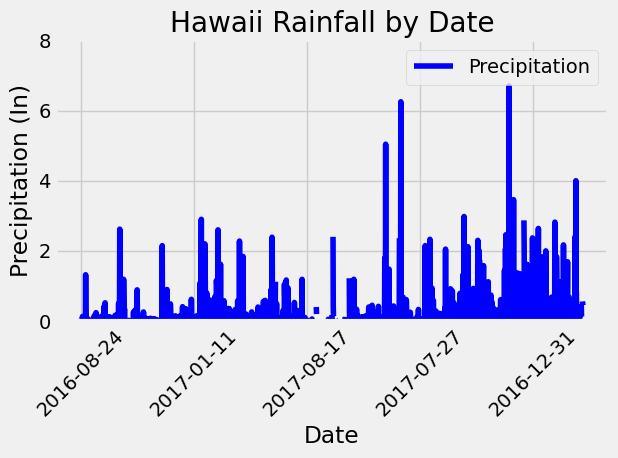

In [23]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# recent_date = datetime.strptime(recent_date[0], '%Y-%m-%d')
one_year_ago = recent_date - timedelta(days=365)
# Calculate the date one year from the last date in data set.
results = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_ago).all()

# df = pd.DataFrame(results, columns=["Date", "Precipitation"])

# Sort the DataFrame by date
# df = df.sort_values(by="Date")

# Use Pandas Plotting with Matplotlib to plot the data
df = pd.DataFrame(results, columns=["date", "Precipitation"])
df.set_index("date", inplace=True)
df.plot(color = "blue", ylim = (0,8), rot = 45)
plt.title("Hawaii Rainfall by Date")
plt.xlabel("Date")
plt.ylabel("Precipitation (In)")
plt.tight_layout()
plt.show()

In [25]:
df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary = df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [29]:
station_num = session.query(station).count()
station_num

9

In [12]:
# Design a query to calculate the total number of stations in the dataset
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

[(9,)]

In [34]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


station_df_info = [station.station, station.name, station.latitude, station.longitude, station.elevation]
station_df_query = session.query(*station_df_info)
station_df = pd.DataFrame(station_df_query)

measurement_df_info = [measurement.station, measurement.date, measurement.prcp, measurement.tobs]
measurement_df_query = session.query(*measurement_df_info)
measurement_df = pd.DataFrame(measurement_df_query)

merge_df = pd.merge(station_df, measurement_df, on="station")
combined = merge_df["station"].value_counts().reset_index()
combined.columns = ['station', 'count']
result = combined.values.tolist()
result

[['USC00519281', 2772],
 ['USC00519397', 2724],
 ['USC00513117', 2709],
 ['USC00519523', 2669],
 ['USC00516128', 2612],
 ['USC00514830', 2202],
 ['USC00511918', 1979],
 ['USC00517948', 1372],
 ['USC00518838', 511]]

In [58]:
most_active_station = combined['station'].value_counts().idxmax()
most_active_station




'USC00519281'

In [38]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

max_temp = session.query(func.max(measurement.tobs)).\
    filter(measurement.station == "USC00519281").scalar()

min_temp = session.query(func.min(measurement.tobs)).\
    filter(measurement.station == "USC00519281").scalar()

avg_temp = round(session.query(func.avg(measurement.tobs)).\
    filter(measurement.station == "USC00519281").scalar(),2)

print(f"Maximum temperature for this station is : {max_temp} degrees\n")

print(f"Minimum temperature for this station is : {min_temp} degrees\n")

print(f"Average temperature for this station is : {avg_temp} degrees")

Maximum temperature for this station is : 85.0 degrees

Minimum temperature for this station is : 54.0 degrees

Average temperature for this station is : 71.66 degrees


In [43]:
most_active_station1 = session.query(measurement.station, measurement.date).\
filter(measurement.station == "USC00519281").\
order_by(measurement.date.desc()).first()

Text(0.5, 4.183333333333314, 'Temperature')

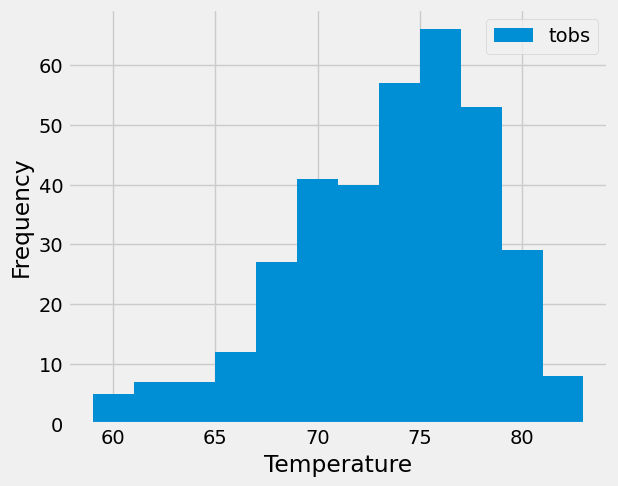

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


# Sort the DataFrame by date

# Use Pandas Plotting with Matplotlib to plot the data
temp_data = session.query(measurement.tobs).\
    filter(measurement.date >= "2016-08-19").\
    filter(measurement.station == "USC00519281").all()

hist, bin_edges = scipy.histogram(temp_data, bins = 12)
plt.bar(bin_edges[:-1], hist, width = 2, color = "blue")
plt.title("Temperature Frequency of Station")
plt.xlabel("Temperature (F)")
plt.ylabel("Occurences")
plt.xlim(min(bin_edges), max(bin_edges)) 
plt.show()

# Close Session

In [66]:
# Close Session
session.close()